# Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from skimage.color import label2rgb
from skimage.measure import regionprops
import os

import time

In [2]:
if not os.path.exists('frames'):
    os.mkdir('frames')
if not os.path.exists('videos'):
    os.mkdir('videos')
if not os.path.exists('frames/all'):
    os.mkdir('frames/all')
if not os.path.exists('videos/all'):
    os.mkdir('videos/all')
if not os.path.exists('img'):
    os.mkdir('img')

# Adjacency Matrix

In [ ]:
# Colour Adjacency matrix derived from
# http://fs.unm.edu/IJMC/BoundsForTheLargestColorEigenvalue.pdf
def adjMatrix(img):
    # Initialize the adjacency matrix to be 0
    row, col, _ = img.shape
    A = np.zeros([row*col,row*col], dtype=int)
    i = 0
    # iterate through each pixel in the image
    for r in range(row):
        for c in range(col):
            px_clr_R = img[r,c,0]
            px_clr_G = img[r,c,1]
            px_clr_B = img[r,c,2]
            # find all pixels that have the same colour 
            # set those values to -1 in the adjacency matrix
            R = (img[:,:,0] == px_clr_R).reshape(-1)
            G = (img[:,:,1] == px_clr_G).reshape(-1)
            B = (img[:,:,2] == px_clr_B).reshape(-1)
            A[i,:] = -1 * R*G*B
            
            # check for adjacent pixels according to 8-connected pixel graph
            # http://www.cb.uu.se/~filip/ImageProcessingUsingGraphs/LectureNotes/Lecture1.pdf
            for r_iter in([-1, 0, 1]):
                for c_iter in([-1, 0, 1]):
                    # calculate current position
                    r_pos = r + r_iter
                    c_pos = c + c_iter
                    # skip if current position is corner
                    if (c_pos) < 0 or (r_pos) < 0 or \
                    (c_pos) > (col-1) or  (r_pos) > (row-1):    
                        pass
                    else:
                        # check if neighbour is same colour
                        if img[r_pos, c_pos, 0] == px_clr_R and \
                            img[r_pos, c_pos, 1] == px_clr_G and \
                            img[r_pos, c_pos, 2] == px_clr_B:
                            # set the value to 1
                            A[i, r_pos*col + c_pos] = 1
            # increment the row
            i += 1
    return A

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
img_clr = np.zeros([row*col,row*col,3],dtype=int)
img_clr[:,:,0] = 255*(A==1)
img_clr[:,:,1] = 255*(A==0)
img_clr[:,:,2] = 255*(A==-1)
plt.imshow(img_clr)

## Grayscale Case

In [ ]:
img = np.array([[0,  0,  0,0],
                [0,255,255,0],
                [0,255,255,0],
                [0,  0,  0,0]])

In [ ]:
# Colour Adjacency matrix derived from
# http://fs.unm.edu/IJMC/BoundsForTheLargestColorEigenvalue.pdf

# Initialize the adjacency matrix to be 0
row, col = img.shape
A = np.zeros([row*col,row*col], dtype=int)
i = 0
# iterate through each pixel in the image
for r in range(row):
    for c in range(col):
        px_clr = img[r,c]
        # find all pixels that have the same colour 
        # set those values to -1 in the adjacency matrix
        A[i,:] = -1*(img == px_clr).reshape(-1)
        
        # check for adjacent pixels according to 8-connected pixel graph
        # http://www.cb.uu.se/~filip/ImageProcessingUsingGraphs/LectureNotes/Lecture1.pdf
        for r_iter in([-1, 0, 1]):
            for c_iter in([-1, 0, 1]):
                # calculate current position
                r_pos = r + r_iter
                c_pos = c + c_iter
                # skip if current position is corner
                if (c_pos) < 0 or (r_pos) < 0 or \
                (c_pos) > (col-1) or  (r_pos) > (row-1):    
                    pass
                else:
                    # check if neighbour is same colour
                    if img[r_pos, c_pos] == px_clr:
                        # set the value to 1
                        A[i, r_pos*col + c_pos] = 1
        # increment the row
        i += 1

# Edge Detection

In [3]:
from scipy.signal import convolve2d

def Gauss2D(k_x, sigma_x, k_y, sigma_y):
    # Inputs
    # k_x: filter radius along x direction
    # sigma_x: sigma along x direction
    # k_y: filter radius along y direction
    # sigma_y: sigma along y direction

    # Outputs:
    # Guassian Kernel of size (2*k_x + 1) x (2*k_y + 1)

    # Gaussian kernel along x
    radius_x = k_x
    x = np.arange(-radius_x, radius_x + 1)            # Generate X values between -k_x to k_x+1
    kernel_x = np.exp(- x**2 / (2 * sigma_x**2))      # Gaussian  Exponential portion
    kernel_x = np.reshape(kernel_x, [2*k_x + 1, 1])   # Reshape into Column Vector

    # Gaussian kernel along y
    radius_y = k_y
    y = np.arange(-radius_y, radius_y + 1)            # Generate Y values between -k_y to k_y+1
    kernel_y = np.exp(- y**2 / (2 * sigma_y**2))      # Gaussian Exponential portion
    kernel_y = np.reshape(kernel_y, [2*k_y + 1, 1])   # Reshape into Column Vector

    gaussKernel = np.dot(kernel_x, kernel_y.T)        # Outter product of X and Y Gaussian Vectors
    gaussKernel = gaussKernel / gaussKernel.sum()     # Normalize the kernel
    return gaussKernel 

def gradMagnitude(img):
    # Inputs
    # img: image f(x,y)

    # Outputs:
    # Gradient Magnitude g(x,y)

    # x and y high-pass filters
    filter_x = np.array([[-1,0,1],
                         [-2,0,2],
                         [-1,0,1]])
    filter_y = np.array([[-1,-2,-1],
                         [0 , 0, 0], 
                         [1 , 2, 1]])
    
    # Compute Sobel operators
    g_x = convolve2d(img, filter_x, mode='same') 
    g_y = convolve2d(img, filter_y, mode='same') 

    return np.sqrt(np.square(g_x) + np.square(g_y))

# @jit
def thresholdAlgorithm(img):
    # Inputs
    # img: image gradient g(x,y)

    # Outputs:
    # edge-mapped image E(x,y)

    # 1. compute initial threshold tao_0 of the image
    tao_0 = img.sum() / (img.shape[0]*img.shape[1])

    # 2. Separate g(x,y) into two classes
    m_H = img * (img > tao_0)               # all entries of image greater than threshold
    m_L = img * (img < tao_0)               # all entries of image smaller than threshold

    # 3. Compute average of mL and mH
    m_H_count = (m_H > 0).sum()
    if m_H_count > 0:
       m_H = m_H.sum() / m_H_count 
    m_L_count = (m_L > 0).sum()
    if m_L_count > 0:
       m_L = m_L.sum() / m_L_count 

    # 4. Update threshold value
    tao_i = (m_L + m_H) / 2

    # 5. Loop while threshold difference above epsilon, small
    tao_test = tao_0
    epi = 1e-4
    i = 0
    while np.absolute(tao_i - tao_test) > epi:
        i += 1
        # 2. Separate g(x,y) into two classes
        tao_test = tao_i
        m_H = img * (img > tao_test)        # all entries of image greater than threshold
        m_L = img * (img < tao_test)        # all entries of image smaller than threshold

        # 3. Compute average of mL and mH
        m_H_count = (m_H > 0).sum()
        if m_H_count > 0:
            m_H = m_H.sum() / m_H_count 
        m_L_count = (m_L > 0).sum()
        if m_L_count > 0:
            m_L = m_L.sum() / m_L_count 
  
        # 4. Update threshold value
        tao_i = (m_L + m_H) / 2

    # print('Loop iterations: ', i)
    # print('Threshold: ', tao_i)
    # Return image gradient where value greater than threshold
    return 1*(img > tao_i), tao_i

In [4]:
def CCL(img):
    # Inputs
    # img: edge-mapped image E(x,y)

    # Outputs:
    # labels: modified image of each connected component labelled
    # currlabel: label of the last connected component found within image

    # Initialize label matrix of size w x h
    x, y = img.shape
    labels = np.zeros([x,y], dtype=int)
    queue = []    # Initialize queue as a list
    
    # 1. Start from first pixel, set current label = 0 as there are none labeled yet
    currLabel = 0
    for i in range(x):
        for j in range(y):
            # 3. pop from queue, look at 8 neighbours
            #       if neighbour is foreground (white), not labelled
            #             give currLabel
            #             add to queue
            # Repeat while queue not empty

            # 2. if pixel is foreground (white) and not labelled, label and add to queue
            #    else, (i.e. background (black) or labelled, next)
            if img[i][j] == 255 and labels[i][j] == 0:
                # print(i, j)
                # 4. increment label as new pixel without label is found
                currLabel += 1
                labels[i][j] = currLabel
                queue.append((i,j))
                # 3. Pop element from queue, label neighbours if foreground, add to queue
                #    loop until queue empty 
                while len(queue) > 0:
                    i_pop, j_pop = queue.pop(0)
                    # loop through all 9 neighbours
                    for i_pop_iter in([-1, 0, 1]):
                        for j_pop_iter in([-1, 0, 1]):
                            # skip if on original pixel
                            if i_pop_iter == 0 and j_pop_iter == 0:
                                pass
                            else:
                                # calculate current position
                                x_pos = i_pop + i_pop_iter
                                y_pos = j_pop + j_pop_iter
                                # skip if current position is corner
                                if (x_pos) < 0 or (y_pos) < 0 or (x_pos) > (x-1) or  (y_pos) > (y-1):    
                                    pass
                                else:
                                    # check if neighbour is foreground (white) and not labelled
                                    if img[x_pos][y_pos] == 255 and labels[x_pos][y_pos] == 0:
                                        # label and add to queue
                                        labels[x_pos][y_pos] = currLabel
                                        queue.append((x_pos,y_pos))
                # # 4. increment label after queue is empty
                # currLabel += 1
    return labels, currLabel

In [5]:
# Visualize Function

# Section adapted from https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html,
# mentioned from https://q.utoronto.ca/courses/181228/discussion_topics/851035 and Q&A session

def visualizeCells(label_image, img):
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=img, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # draw rectangle around segmented cells
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig('img_CCL.png', cmap='gray')
    plt.show()

# Testing Algorithm

### Load Image and Calculate Grad/Edges

0.08464956283569336


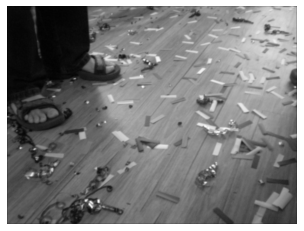

0.059606313705444336


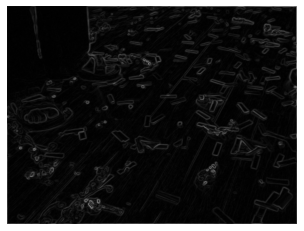

0.12559914588928223


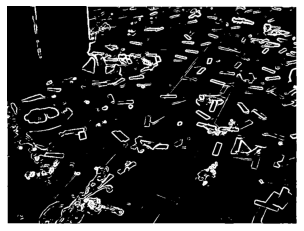

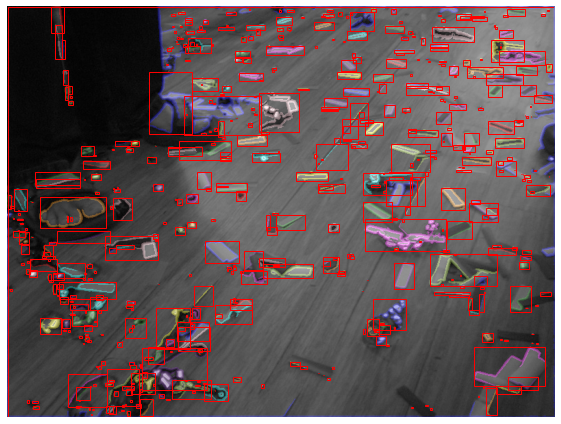

In [7]:
# img = cv2.imread('img0035.png', 0)
# img_clr = cv2.imread('img0035.png')
img = cv2.imread('img0036.png', 0)
img_clr = cv2.imread('img0036.png')
# img = cv2.imread('img0037.png', 0)
# img_clr = cv2.imread('img0037.png')
# plt.imshow(img, cmap='gray')
# plt.axis('off')
# plt.show()

s = time.time()
gaussFilter = Gauss2D(5, 2, 5, 2)
gaussFilter = Gauss2D(3, 1, 3, 1)
img_G = convolve2d(img, gaussFilter, mode='same')
print(time.time() - s)
cv2.imwrite('img_G.png',img_G)
plt.imshow(img_G, cmap='gray')
plt.axis('off')
plt.show()

s = time.time()
img_grad = gradMagnitude(img_G)
# img_grad = gradMagnitude(img)
print(time.time() - s)
cv2.imwrite('img_grad.png',img_grad)
plt.imshow(img_grad, cmap='gray')
plt.axis('off')
plt.show()

img_grad = img_grad/img_grad.max()*255

s = time.time()
img_edge, threshold = thresholdAlgorithm(img_grad)
print(time.time() - s)
cv2.imwrite('img_edge.png',255*img_edge)
plt.imshow(img_edge, cmap='gray')
plt.axis('off')
plt.show()

labeledImage, _ = CCL(255*img_edge)
visualizeCells(labeledImage, img)

### Shared Functions

In [13]:
def confettiRemoval(coords1,coords2,currLabel,currBox,tau,img,img_clr,img_grad,img_edge):
    rmin_PAD = coords1[0]
    cmin_PAD = coords1[1]
    rmax_PAD = coords2[0]
    cmax_PAD = coords2[1]
    
    img_C = img[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]
    img_clr_C = img_clr[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD,:]
    img_grad_C = img_grad[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]
    img_edge_C = img_edge[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]

    for ctr in range(CTR):
    # for ctr in range(30):
        # print('Iteration:', ctr+1)

        # area of interest
        # img_C = img[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]
        # img_clr_C = img_clr[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD,:]
        # img_grad_C = img_grad[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]
        # img_edge_C = img_edge[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]

        visited = np.zeros(np.shape(img_edge_C))
        rows, cols = np.where(img_edge_C == 1)
        nodes = []
        for i in range(len(rows)):
            row, col = rows[i], cols[i]
            # only edge pixels not in PADDED area
            if row > minr or col < minc or row > maxr or col < maxc:
                nodes.append((row,col))

        # up down, left right
        directions = [(-1,0),(1,0),(0,-1),(0,1)]
        # directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
        R = 5
        while len(nodes) > 0:
            # current edge coords
            row, col = nodes.pop(0)
            # only visit node if not visited before
            if visited[row, col] == 0:
                visited[row, col] = 1
                sum_k = []
                for d in directions:
                    # avoid direction if edge 
                    if img_edge_C[row+d[0]-1, col+d[1]-1] != 255:
                        curr_sum = 0
                        for r in range(R):
                            # calculate current position
                            r_pos = row+d[0]*r
                            c_pos = col+d[1]*r

                            # skip if current position is outside image
                            if (c_pos) < 0 or (r_pos) < 0 or (c_pos) > (img_C.shape[1]-1) or  (r_pos) > (img_C.shape[0]-1):    
                                pass
                            else:
                                curr_sum += np.abs(int(img_grad_C[row,col]) - int(img_grad_C[r_pos,c_pos]))
                        sum_k.append(curr_sum)
                    
                # take max direction and value
                max_d = np.argmax(sum_k)

                best_dir = directions[max_d]
                # replace current pixel value with the new pixel value
                img_C[row,col] = img_C[row+best_dir[0],col+best_dir[1]]
                img_clr_C[row,col,0] = img_clr_C[row+best_dir[0],col+best_dir[1],0]
                img_clr_C[row,col,1] = img_clr_C[row+best_dir[0],col+best_dir[1],1]
                img_clr_C[row,col,2] = img_clr_C[row+best_dir[0],col+best_dir[1],2]
                # add node in that direction onto list
                # nodes.append((row-best_dir[0],col-best_dir[1]))
        
        # update section
        img[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD] = img_C
        img_clr[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD,:] = img_clr_C
        
        img_G_update = convolve2d(img_C, gaussFilter, mode='same')
        img_grad_C = gradMagnitude(img_G_update)
        img_edge_C = 1*(img_grad_C > tau)

        # img_G_update = convolve2d(img_C, gaussFilter, mode='same')
        # img_grad_update = gradMagnitude(img_G_update)
        # img_grad_update = img_grad_update/img_grad_update.max()*255
        # img_edge_update = 1*(img_grad_update > tau)

        r_left = (minr-rmin_PAD)*(minr != rmin_PAD)
        r_right = (rmax_PAD-maxr)*(maxr != rmax_PAD)
        col_top = (minc-cmin_PAD)*(minc != cmin_PAD)
        col_bot = (cmax_PAD-maxc)*(maxc != cmax_PAD)
        # print(r_left,r_right,col_top,col_bot)
        # print(minr,rmin_PAD)
        # print(maxr,rmax_PAD)

        img_grad[minr:maxr,minc:maxc] = img_grad_C[r_left:rmax_PAD-rmin_PAD-r_right,col_top:cmax_PAD-cmin_PAD-col_bot]
        img_edge[minr:maxr,minc:maxc] = img_edge_C[r_left:rmax_PAD-rmin_PAD-r_right,col_top:cmax_PAD-cmin_PAD-col_bot]
        # img_grad[minr:maxr,minc:maxc] = img_grad_update[r_left:rmax_PAD-rmin_PAD-r_right,col_top:cmax_PAD-cmin_PAD-col_bot]
        # img_edge[minr:maxr,minc:maxc] = img_edge_update[r_left:rmax_PAD-rmin_PAD-r_right,col_top:cmax_PAD-cmin_PAD-col_bot]

        # save current frame
        # cv2.imwrite('frames/{}/img_clr_C_{}.png'.format(currLabel,ctr),img_clr_C)
        # cv2.imwrite('frames/{}/img_edge_C_{}.png'.format(currLabel,ctr),255*img_edge_C)

        img_clr_R = img_clr.copy()
        # draw red box
        img_clr_R[rmin_PAD:rmax_PAD,cmin_PAD,2] = 255
        img_clr_R[rmin_PAD:rmax_PAD,cmin_PAD,0:2] = 0

        img_clr_R[rmin_PAD:rmax_PAD-1,cmax_PAD-1,2] = 255
        img_clr_R[rmin_PAD:rmax_PAD-1,cmax_PAD-1,0:2] = 0

        img_clr_R[rmin_PAD,cmin_PAD:cmax_PAD-1,2] = 255
        img_clr_R[rmin_PAD,cmin_PAD:cmax_PAD-1,0:2] = 0

        img_clr_R[rmax_PAD-1,cmin_PAD:cmax_PAD-1,2] = 255
        img_clr_R[rmax_PAD-1,cmin_PAD:cmax_PAD-1,0:2] = 0

        
        img_edge_R = np.zeros((img_edge.shape[0],img_edge.shape[1],3))
        img_edge_R[img_edge == 1,:] = 255

        # draw red box
        img_edge_R[rmin_PAD:rmax_PAD,cmin_PAD,2] = 255
        img_edge_R[rmin_PAD:rmax_PAD,cmin_PAD,0:2] = 0

        img_edge_R[rmin_PAD:rmax_PAD-1,cmax_PAD-1,2] = 255
        img_edge_R[rmin_PAD:rmax_PAD-1,cmax_PAD-1,0:2] = 0

        img_edge_R[rmin_PAD,cmin_PAD:cmax_PAD-1,2] = 255
        img_edge_R[rmin_PAD,cmin_PAD:cmax_PAD-1,0:2] = 0

        img_edge_R[rmax_PAD-1,cmin_PAD:cmax_PAD-1,2] = 255
        img_edge_R[rmax_PAD-1,cmin_PAD:cmax_PAD-1,0:2] = 0

        cv2.imwrite('frames/all/img_clr_{}.png'.format(currBox*CTR+ctr),img_clr_R)
        cv2.imwrite('frames/all/img_edge_{}.png'.format(currBox*CTR+ctr),img_edge_R)

    # return images
    return img,img_clr,img_grad,img_edge

# def generateVideos(currLabel):
#     # Generate Videos out of all the frames
#     img_array = []

#     for i in range(CTR):
#         filename = 'frames/{}/img_clr_C_{}.png'.format(currLabel,i)
#         img_temp = cv2.imread(filename)
#         height, width, layers = img_temp.shape
#         size = (width,height)
#         img_array.append(img_temp)


#     out = cv2.VideoWriter('videos/{}/img_clr_C.avi'.format(currLabel),cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

#     for i in range(len(img_array)):
#         out.write(img_array[i])
#     out.release()


#     img_array = []

#     for i in range(CTR):
#         filename = 'frames/{}/img_edge_C_{}.png'.format(currLabel,i)
#         img_temp = cv2.imread(filename)
#         height, width, layers = img_temp.shape
#         size = (width,height)
#         img_array.append(img_temp)


#     out = cv2.VideoWriter('videos/{}/img_edge_C.avi'.format(currLabel),cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

#     for i in range(len(img_array)):
#         out.write(img_array[i])
#     out.release()

def generateOverallVideo(numFrames):
    # Generate Videos out of all the frames
    img_array = []

    for i in range(numFrames):
        filename = 'frames/all/img_clr_{}.png'.format(i)
        img_temp = cv2.imread(filename)
        height, width, layers = img_temp.shape
        size = (width,height)
        img_array.append(img_temp)


    out = cv2.VideoWriter('videos/all/img_clr.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()


    img_array = []

    for i in range(numFrames):
        filename = 'frames/all/img_edge_{}.png'.format(i)
        img_temp = cv2.imread(filename)
        height, width, layers = img_temp.shape
        size = (width,height)
        img_array.append(img_temp)


    out = cv2.VideoWriter('videos/all/img_edge.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [9]:
def plotFigures(coords1, coords2, currLabel, state):
    rmin_PAD = coords1[0]
    cmin_PAD = coords1[1]
    rmax_PAD = coords2[0]
    cmax_PAD = coords2[1]
    
    img_C = img[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]
    img_clr_C = img_clr[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD,:]
    img_grad_C = img_grad[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]
    img_edge_C = img_edge[rmin_PAD:rmax_PAD,cmin_PAD:cmax_PAD]


    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 10)
    ax1.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax = plt.gca()
    ax1.add_patch(Rectangle((cmin_PAD,rmin_PAD),cmax_PAD-cmin_PAD,rmax_PAD-rmin_PAD,linewidth=1
                     ,edgecolor='r',facecolor='none'))
    ax2.imshow(img_edge, cmap='gray')
    ax2.axis('off')
    ax2.add_patch(Rectangle((cmin_PAD,rmin_PAD),cmax_PAD-cmin_PAD,rmax_PAD-rmin_PAD,linewidth=1
                     ,edgecolor='r',facecolor='none'))
    plt.savefig('img/{}/img_redbox_{}.png'.format(currLabel,state),
                bbox_inches='tight', pad_inches=1)
    # plt.show()
    plt.close()


    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(9, 3)
    ax1.imshow(cv2.cvtColor(img_clr_C, cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax2.imshow(img_C, cmap='gray')
    ax2.axis('off')
    ax3.imshow(img_edge_C, cmap='gray')
    ax3.axis('off')
    plt.savefig('img/{}/img_zoomed_{}.png'.format(currLabel,state),
                bbox_inches='tight', pad_inches=1)
    # plt.show()
    plt.close()

    cv2.imwrite('img/{}/img_clr_C_{}.png'.format(currLabel,state),img_clr_C)
    cv2.imwrite('img/{}/img_edge_C_{}.png'.format(currLabel,state),255*img_edge_C)


## Testing - All pieces

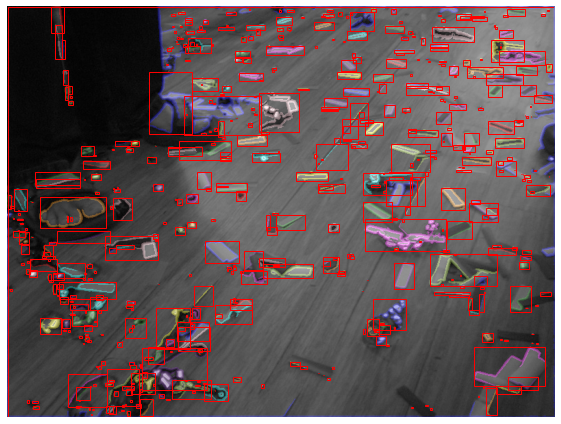

In [10]:
# img = cv2.imread('img0035.png', 0)
# img_clr = cv2.imread('img0035.png')
img = cv2.imread('img0036.png', 0)
img_clr = cv2.imread('img0036.png')
# img = cv2.imread('img0037.png', 0)
# img_clr = cv2.imread('img0037.png')
gaussFilter = Gauss2D(3, 1, 3, 1)
# gaussFilter = Gauss2D(5, 2, 5, 2)
img_G = convolve2d(img, gaussFilter, mode='same')
img_grad = gradMagnitude(img_G)
# img_grad = gradMagnitude(img)
img_grad = img_grad/img_grad.max()*255
img_edge, tau = thresholdAlgorithm(img_grad)
labeledImage, _ = CCL(255*img_edge)
visualizeCells(labeledImage, img)

In [14]:
row, col = labeledImage.shape
PAD = 5
MIN_SIZE = 5
MAX_SIZE = 50

# CTR = 10
# CTR = 30
# CTR = 50
# at most radially removed this many pixels
CTR = MAX_SIZE // 2
cv2.imwrite('img_clr_init.png',img_clr)
cv2.imwrite('img_edge_init.png',img_edge*255)

currBox = 0
for i, region in enumerate(regionprops(labeledImage)):
    # draw rectangle around segmented cells
    minr, minc, maxr, maxc = region.bbox

    # limit size of confetti
    # if (maxr-minr) < 300 and (maxc-minc) < 300 and (maxr-minr) > 30 and (maxc-minc) > 30:
    if (maxr-minr) < MAX_SIZE and (maxc-minc) < MAX_SIZE and (maxr-minr) > MIN_SIZE and (maxc-minc) > MIN_SIZE:
    # if (maxr-minr) < 50 and (maxc-minc) < 50 and (maxr-minr) > 5 and (maxc-minc) > 5 and i == 385:
        
        # pad the rectangle
        minr_PAD = max(minr - PAD, 0)
        minc_PAD = max(minc - PAD, 0)
        maxr_PAD = min(maxr + PAD, row)
        maxc_PAD = min(maxc + PAD, col)

        coords1 = (minr_PAD,minc_PAD)
        coords2 = (maxr_PAD,maxc_PAD)
        print(i)
        print(coords1,coords2)
        img,img_clr,img_grad,img_edge = confettiRemoval(coords1,coords2,i,currBox,tau,img,img_clr,img_grad,img_edge)

        # # create directory for current label
        # if not os.path.exists('img/{}'.format(i)):
        #    os.mkdir('img/{}'.format(i))
           
        # # create frames and videos directory
        # if not os.path.exists('frames/{}'.format(i)):
        #    os.mkdir('frames/{}'.format(i))
        # if not os.path.exists('videos/{}'.format(i)):
        #    os.mkdir('videos/{}'.format(i))
        # plotFigures(coords1,coords2,i,'og')
        # img,img_clr,img_grad,img_edge = confettiRemoval(coords1,coords2,i,currBox,tau,img,img_clr,img_grad,img_edge)
        # generateVideos(i)
        # plotFigures(coords1,coords2,i,'rem')
        currBox += 1

cv2.imwrite('img_clr_final.png',img_clr)
cv2.imwrite('img_edge_final.png',img_edge*255)
generateOverallVideo(currBox*CTR)


0
(0, 59) (44, 87)
3
(0, 556) (15, 573)
4
(0, 725) (18, 762)
11
(2, 495) (40, 541)
14
(3, 478) (19, 494)
17
(5, 650) (24, 682)
27
(10, 388) (31, 421)
30
(10, 674) (26, 706)
31
(11, 254) (27, 274)
33
(14, 281) (30, 298)
34
(15, 255) (31, 274)
36
(18, 443) (39, 483)
37
(21, 344) (39, 381)
44
(23, 547) (43, 585)
50
(27, 358) (46, 374)
53
(29, 714) (50, 744)
57
(31, 492) (53, 531)
64
(39, 336) (57, 353)
67
(40, 259) (72, 303)
68
(40, 599) (61, 616)
72
(43, 702) (86, 760)
84
(53, 255) (72, 287)
94
(60, 328) (78, 360)
97
(68, 500) (87, 522)
98
(70, 327) (86, 348)
99
(70, 339) (87, 361)
100
(71, 549) (94, 588)
105
(73, 483) (99, 514)
106
(73, 661) (92, 681)
112
(79, 782) (100, 800)
113
(81, 641) (105, 664)
114
(82, 739) (105, 779)
118
(88, 76) (119, 94)
122
(91, 477) (111, 522)
123
(92, 333) (113, 379)
124
(93, 529) (115, 569)
129
(99, 265) (128, 312)
131
(106, 577) (124, 620)
133
(108, 538) (131, 558)
134
(110, 698) (137, 728)
135
(110, 744) (136, 778)
137
(111, 309) (129, 331)
141
(114, 486

## Saving to drive

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
!cp -R /content/videos/* '/content/drive/MyDrive/University/4b. Fourth Year/CSC420 - PepeWritesCode/images/ScatterInpaintingOutput'

In [22]:
!cp -R /content/img_clr_final.png '/content/drive/MyDrive/University/4b. Fourth Year/CSC420 - PepeWritesCode/images/ScatterInpaintingOutput'
!cp -R /content/img_edge_init.png '/content/drive/MyDrive/University/4b. Fourth Year/CSC420 - PepeWritesCode/images/ScatterInpaintingOutput'
!cp -R /content/img_edge_final.png '/content/drive/MyDrive/University/4b. Fourth Year/CSC420 - PepeWritesCode/images/ScatterInpaintingOutput'

## Testing

In [ ]:
coords1 = (17, 3754)
coords2 = (30, 3765)

rmin_PAD = min(coords1[0],coords2[0])
rmax_PAD = max(coords1[0],coords2[0])
c_min = min(coords1[1],coords2[1])
c_max = max(coords1[1],coords2[1])
PAD = 5
img_clr_C = img_clr[r_min-PAD:rmax_PAD+PAD,c_min-PAD:c_max+PAD,:]
plt.imshow(cv2.cvtColor(img_clr_C, cv2.COLOR_BGR2RGB))


In [ ]:
plotFigures(coords1, coords2)

In [ ]:
img,img_clr,img_grad,img_edge = confettiRemoval(coords1,coords2,img,img_clr,img_grad,img_edge)

In [ ]:
plotFigures(coords1, coords2)

# Old Algorithm

In [ ]:
img_C = img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
img_clr_C = img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:]
img_grad_C = img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
img_edge_C = img_edge[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]

ctr = 0
while np.sum(img_edge_C) > 0:
    # area of interest
    img_C = img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
    img_clr_C = img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:]
    img_grad_C = img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
    img_edge_C = img_edge[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]

    visited = np.zeros(np.shape(img_edge_C))
    rows, cols = np.where(img_edge_C == 1)
    nodes = []
    for i in range(len(rows)):
        row, col = rows[i], cols[i]
        nodes.append((row,col))

    # up down, left right
    # directions = [(-1,0),(1,0),(0,-1),(0,1)]
    directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    R = 5
    while len(nodes) > 0:
        # current edge coords
        row, col = nodes.pop(0)
        # only visit node if not visited before
        if visited[row, col] == 0:
            visited[row, col] = 1
            sum_k = []
            for d in directions:
                curr_sum = 0
                for r in range(R):
                    # curr_sum += np.abs(int(img_C[row,col])- 
                                    # int(img_C[row+d[0]*r,col+d[1]*r]))/255*(R-r+1)
                    # curr_sum += img_grad_C[row+d[0]*r,col+d[1]*r]
                    curr_sum += np.abs(int(img_grad_C[row,col]) - int(img_grad_C[row+d[0]*r,col+d[1]*r]))#/255*(R-r+1)
                sum_k.append(curr_sum)
            
            # take max direction and value
            max_d = np.argmax(sum_k)
            # take min direction and value
            min_d = np.argmin(sum_k)

            best_dir = directions[max_d]
            # replace current pixel value with the new pixel value
            img_C[row,col] = img_C[row+best_dir[0],col+best_dir[1]]
            img_clr_C[row,col,0] = img_clr_C[row+best_dir[0],col+best_dir[1],0]
            img_clr_C[row,col,1] = img_clr_C[row+best_dir[0],col+best_dir[1],1]
            img_clr_C[row,col,2] = img_clr_C[row+best_dir[0],col+best_dir[1],2]
            # add node in that direction onto list
            # nodes.append((row-best_dir[0],col-best_dir[1]))
    
    # save current frame
    cv2.imwrite('frames/img_clr_C_{}.png'.format(ctr),img_clr_C)
    cv2.imwrite('frames/img_edge_C_{}.png'.format(ctr),255*img_edge_C)
    ctr += 1

    img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD] = img_C
    img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:] = img_clr_C
    img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD] = img_grad_C 
    img_G = convolve2d(img, gaussFilter, mode='same')
    img_grad = gradMagnitude(img_G)
    img_grad = img_grad/img_grad.max()*255
    img_edge = thresholdAlgorithm(img_grad)